In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from umap import JUMAP

import velocyto as vcy
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
#import protaccel.protaccel as pa
#import sys
#sys.path.insert(0, '/home/vanhoan310/python_code/sc_velocity/')
import pa
from joint_velo_UMAP import *

In [3]:
[prot_count_array,prot_cells,adt_names] = pa.import_prot_data('/data/hoan/sc_velocity/data/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv')

In [4]:
print(adt_names)


['CD3' 'CD4' 'CD8' 'CD2' 'CD45RA' 'CD57' 'CD16' 'CD14' 'CD11c' 'CD19']


In [5]:
vlm = vcy.VelocytoLoom("/data/hoan/sc_velocity/data/SPBMC_run3.loom")


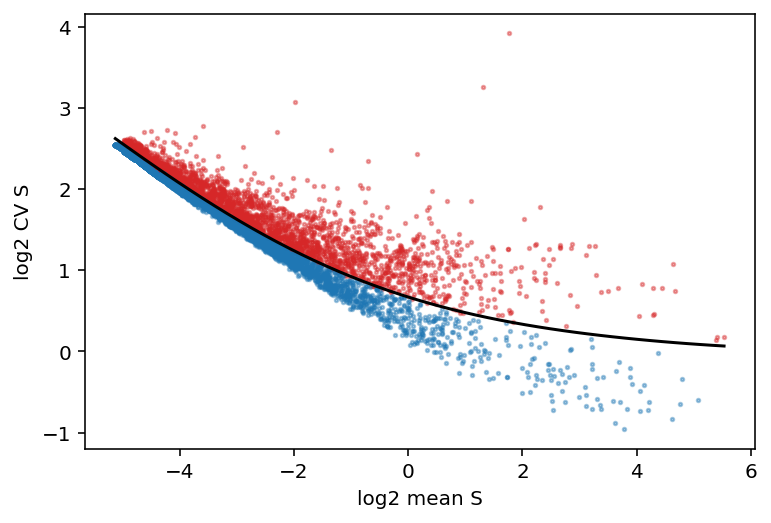

In [6]:
# select 3K genes with highest variance
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

In [7]:
# define relationship between proteins and source mRNA. Define mRNA to be used for phase portrait visulization
gene_dict = {'CD3':['CD3D','CD3E','CD3G'], 
             'CD4':['CD4'],
             'CD8':['CD8A','CD8B'],
             'CD2':['CD2'],
             'CD45RA':['PTPRC'],
             'CD57':['B3GAT1'],
             'CD16':['FCGR3A','FCGR3B'],
             'CD14':['CD14'],
             'CD11c':['ITGAX'],
             'CD19':['CD19']}

InvertDict = lambda d: dict( (v,k) for k in d for v in d[k] )


mrna_targets = ['CD3D','CD3E','CD3G','CD4','CD8A','CD8B','CD2',
                'PTPRC','FCGR3A','CD14','ITGAX','CD19']

In [8]:
# define inverse relationship
prot_dict = InvertDict(gene_dict)

In [9]:
# Append genes that yield observed proteins even if variability is relatively low for RNA velocity phase plots. Filter genes. Save ADT names.
pa.enforce_protein_filter(vlm, mrna_targets, adt_names)
vlm.filter_genes(by_cv_vs_mean=True,by_detection_levels=True)

In [10]:
# Check format of intersection cell IDs. Filter for intersection of cell UMIs.

first_char = vlm.ca['CellID'][0].find(':')+1
last_char = -1

[prot_count_array, shared_cells, prot_cells] = pa.shared_cells_filter(vlm, prot_cells, prot_count_array, first_char, last_char)

ADT cell number: 7985
RNAseq cell number: 1789
Shared cells: 1780
Shared cells with more than 5 molecules: 1780


In [11]:
# perform imputation using protein space
pa.impute(vlm, prot_count_array, k=30, impute_in_prot_space=True, size_norm=False, impute_in_pca_space=False)

In [12]:
# find clusters in protein space in order to identify cell types
t_cl = [0, 1, 2, 3, 3, 4, 2, 3, 4]
[cluster_ID, num_clusters] = pa.identify_clusters(vlm,vlm.connectivity,
                                                  correct_tags=True,tag_correction_list=t_cl,
                                                  method_name='ModularityVertexPartition',seed=4)

In [13]:
# COLORS=np.asarray([[0, 0.4470, 0.7410], #CD4
#                     [0.9290, 0.6940, 0.1250], #B
#                     [0.4940, 0.1840, 0.5560], #Mono
#                     [0.4660, 0.6740, 0.1880], #NK
#                     [0.8500, 0.3250, 0.0980] #CD8
#                   ])
COLORS=np.asarray([ [0.4660, 0.6740, 0.1880], #NK
                    [0.9290, 0.6940, 0.1250], #B
                    [0, 0.4470, 0.7410], #CD4
                    [0.4940, 0.1840, 0.5560], #Mono
                    [0.8500, 0.3250, 0.0980] #CD8
                  ])

In [14]:
cluster_labels = ["NK", "B", "CD4 T", "Mono", "CD8"]
vlm.COLORS = COLORS
vlm.labels=cluster_labels

In [15]:
# Visualize clusters in PC1/2 and PC2/3.
pa.fit_pcs(vlm,'P_norm','prot_pcs',n_pcs=10)
pa.fit_tsne(vlm, 'prot_pcs', 'prot_tsne', 8, seed=20)

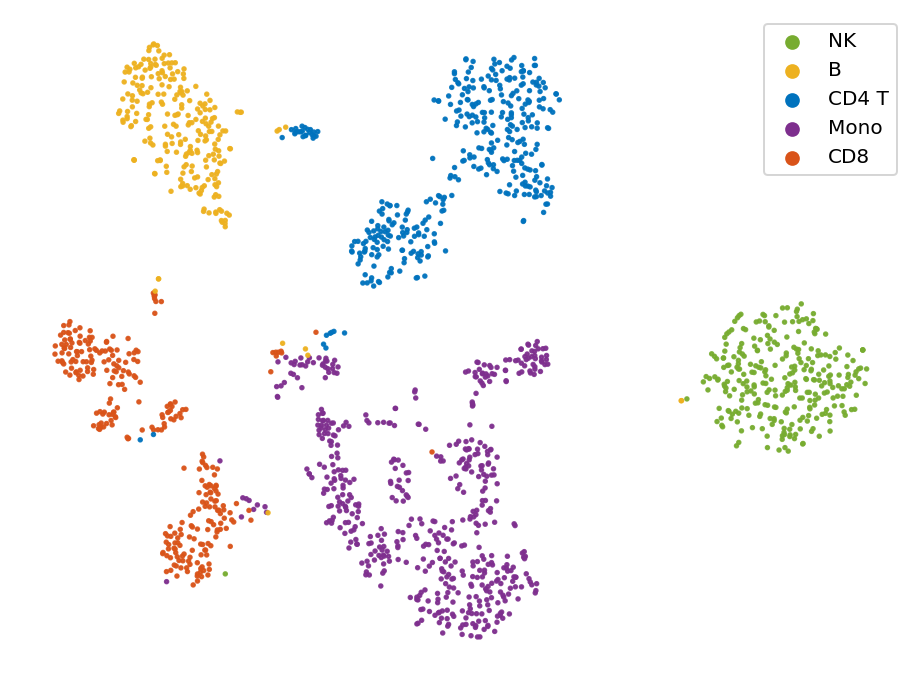

In [16]:
# pa.visualize_pcs(vlm,  [1,2])
pa.visualize_pcs(vlm, [1,2], 'prot_tsne')
#plt.savefig("fig/cite_tsne.svg")

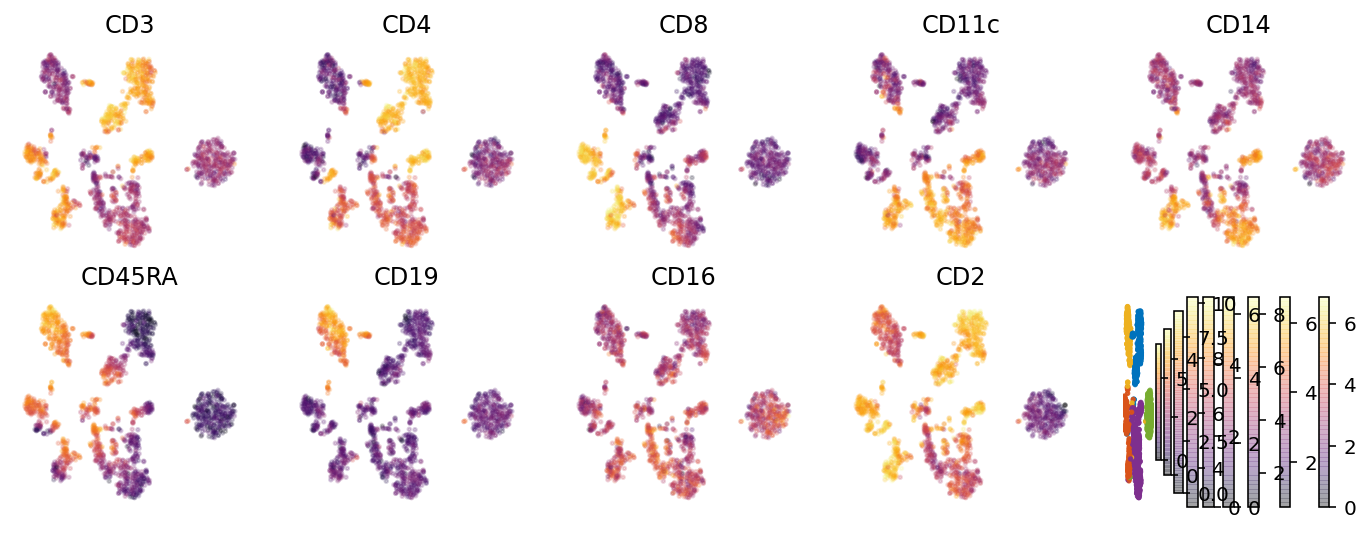

In [17]:
marker_list = ['CD3','CD4','CD8','CD11c','CD14','CD45RA','CD19','CD16','CD2']
visualize_protein_markers_tsne(vlm, protein_markers=marker_list, pc_targets=[1,2], visualize_clusters= True)
#plt.savefig("fig/cite_clus1.svg")
#pa.visualize_protein_markers(vlm, protein_markers=marker_list, pc_targets=[2,3], visualize_clusters= True)
#plt.savefig("fig/cite_clus2.svg")

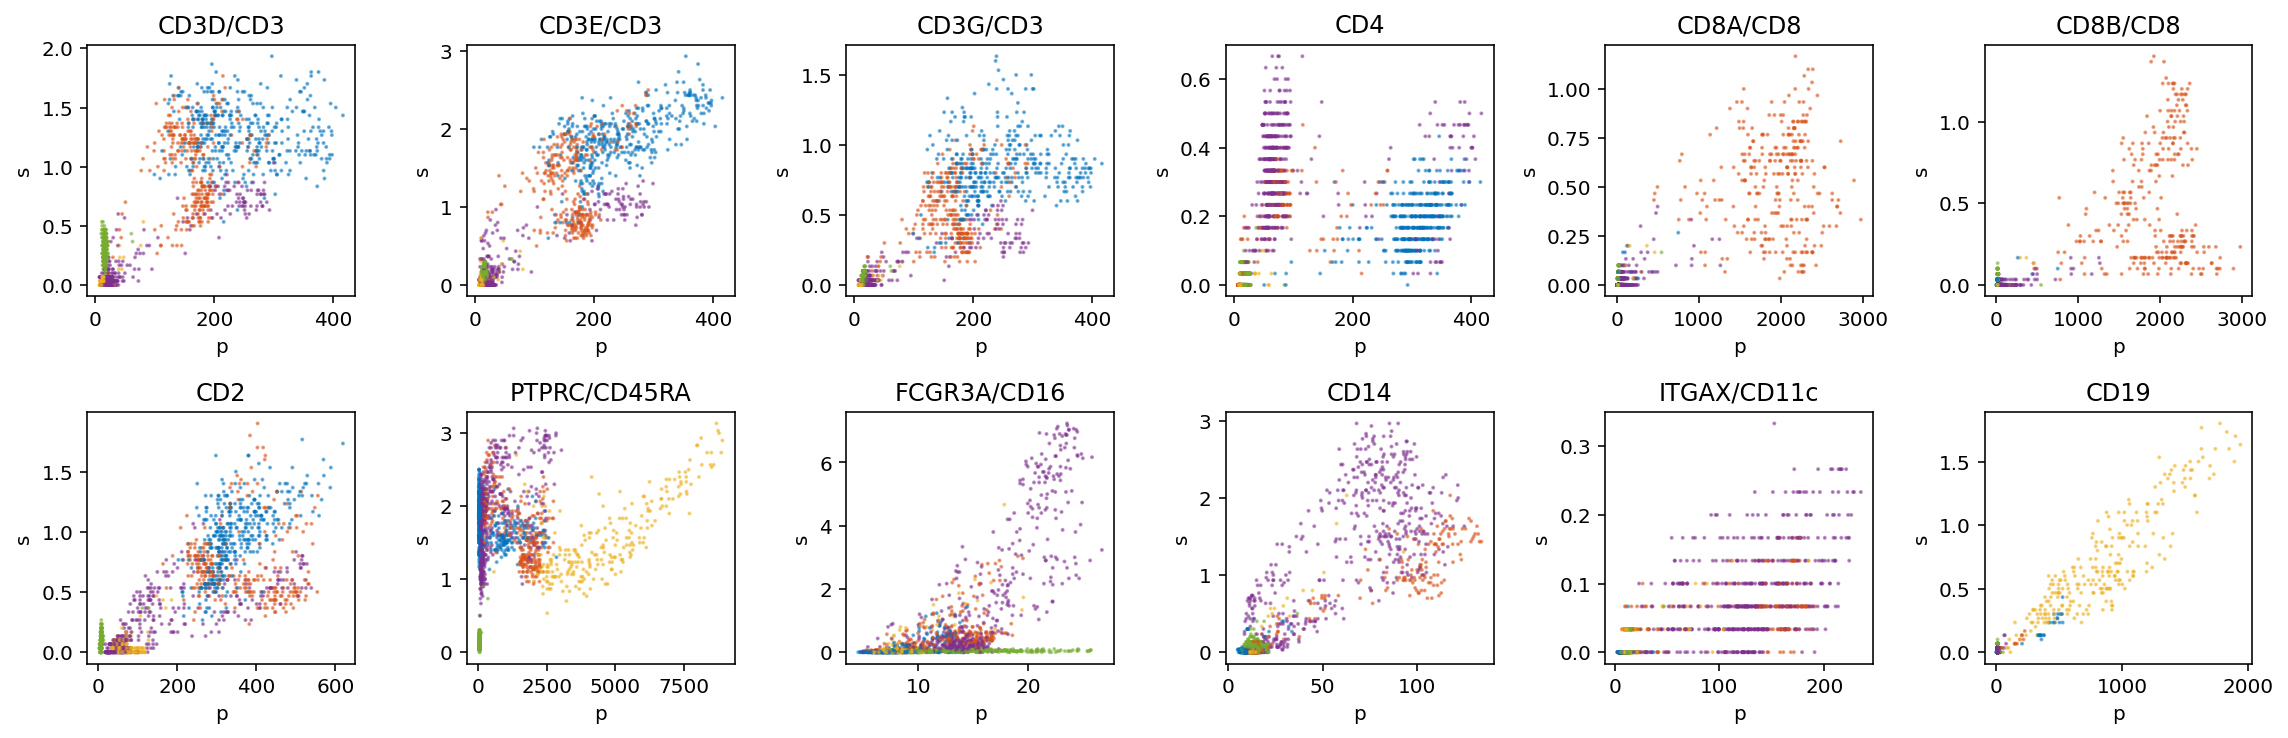

In [18]:
pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict)


In [19]:
# Manually select RNA/protein pairs with reasonably diagonal plots for protein velocity.
genes_used_for_prot_velocity = ['CD3D','CD8A','FCGR3A','CD14','ITGAX','CD19','CD2']
adt_used_for_prot_velocity = ['CD3','CD8','CD16','CD14','CD11c','CD19','CD2']

In [20]:
target_size_median = [np.median(vlm.S.sum(0)), np.median(vlm.U.sum(0))]
vlm.normalize(which="both",size=True,target_size=target_size_median)
pa.fit_pcs(vlm,'S_norm','pcs',3)

In [21]:
# Fit degradation parameters and extrapolate
pa.gamma_fit(vlm,'Sx','Ux','rna')
pa.extrapolate(vlm,vel_type='rna')
pa.gamma_fit(vlm,'Px','Sx','protein',genes_used_for_prot_velocity, adt_used_for_prot_velocity)
pa.extrapolate(vlm,vel_type='protein')

In [22]:
# exam parameters
n_rna_velo_fit_viz = 24
np.random.seed(948329843)
print(str(len(vlm.rna_velo_gene_ind))+' spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying '\
      +str(n_rna_velo_fit_viz)+' random phase portraits:')
genes_for_rna_velo_fit=np.random.choice(vlm.rna_velo_gene_ind,n_rna_velo_fit_viz,replace=False)

692 spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying 24 random phase portraits:


In [23]:
rna_vel_genes=vlm.ra['Gene'][genes_for_rna_velo_fit]
# pa.visualize_phase_portraits(vlm, rna_vel_genes, target='mrna', plot_fit=True)

In [24]:
# Project velocity direction into the embedding using the transition matrix method.
pa.identify_embedding_knn(vlm,'pcs',[1,2])


In [25]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_pca','rna_velo_gene_ind')


In [26]:
# plot RNA velocity on RNA embedding
# pa.visualize_velocity_projection(vlm, 'delta_S_in_S_pca')


In [27]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_pca','prot_velo_prot_ind')


In [28]:
# plot protein velocity on RNA embedding
# pa.visualize_velocity_projection(vlm, 'delta_P_in_S_pca')


In [29]:
# Visualize cluster-specific velocities.
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_pca',draw_cells=True)
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_pca',draw_cells=True)


In [30]:
# Prepare and perform grid embedding.
pa.initialize_grid_embedding(vlm)
uv_multiplier=1.2
pa.calculate_grid_arrows(vlm,'delta_S_in_S_pca', '_rna', min_mass=5,uv_multiplier=uv_multiplier+1.0)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_pca', '_prot', min_mass=5,uv_multiplier=uv_multiplier)

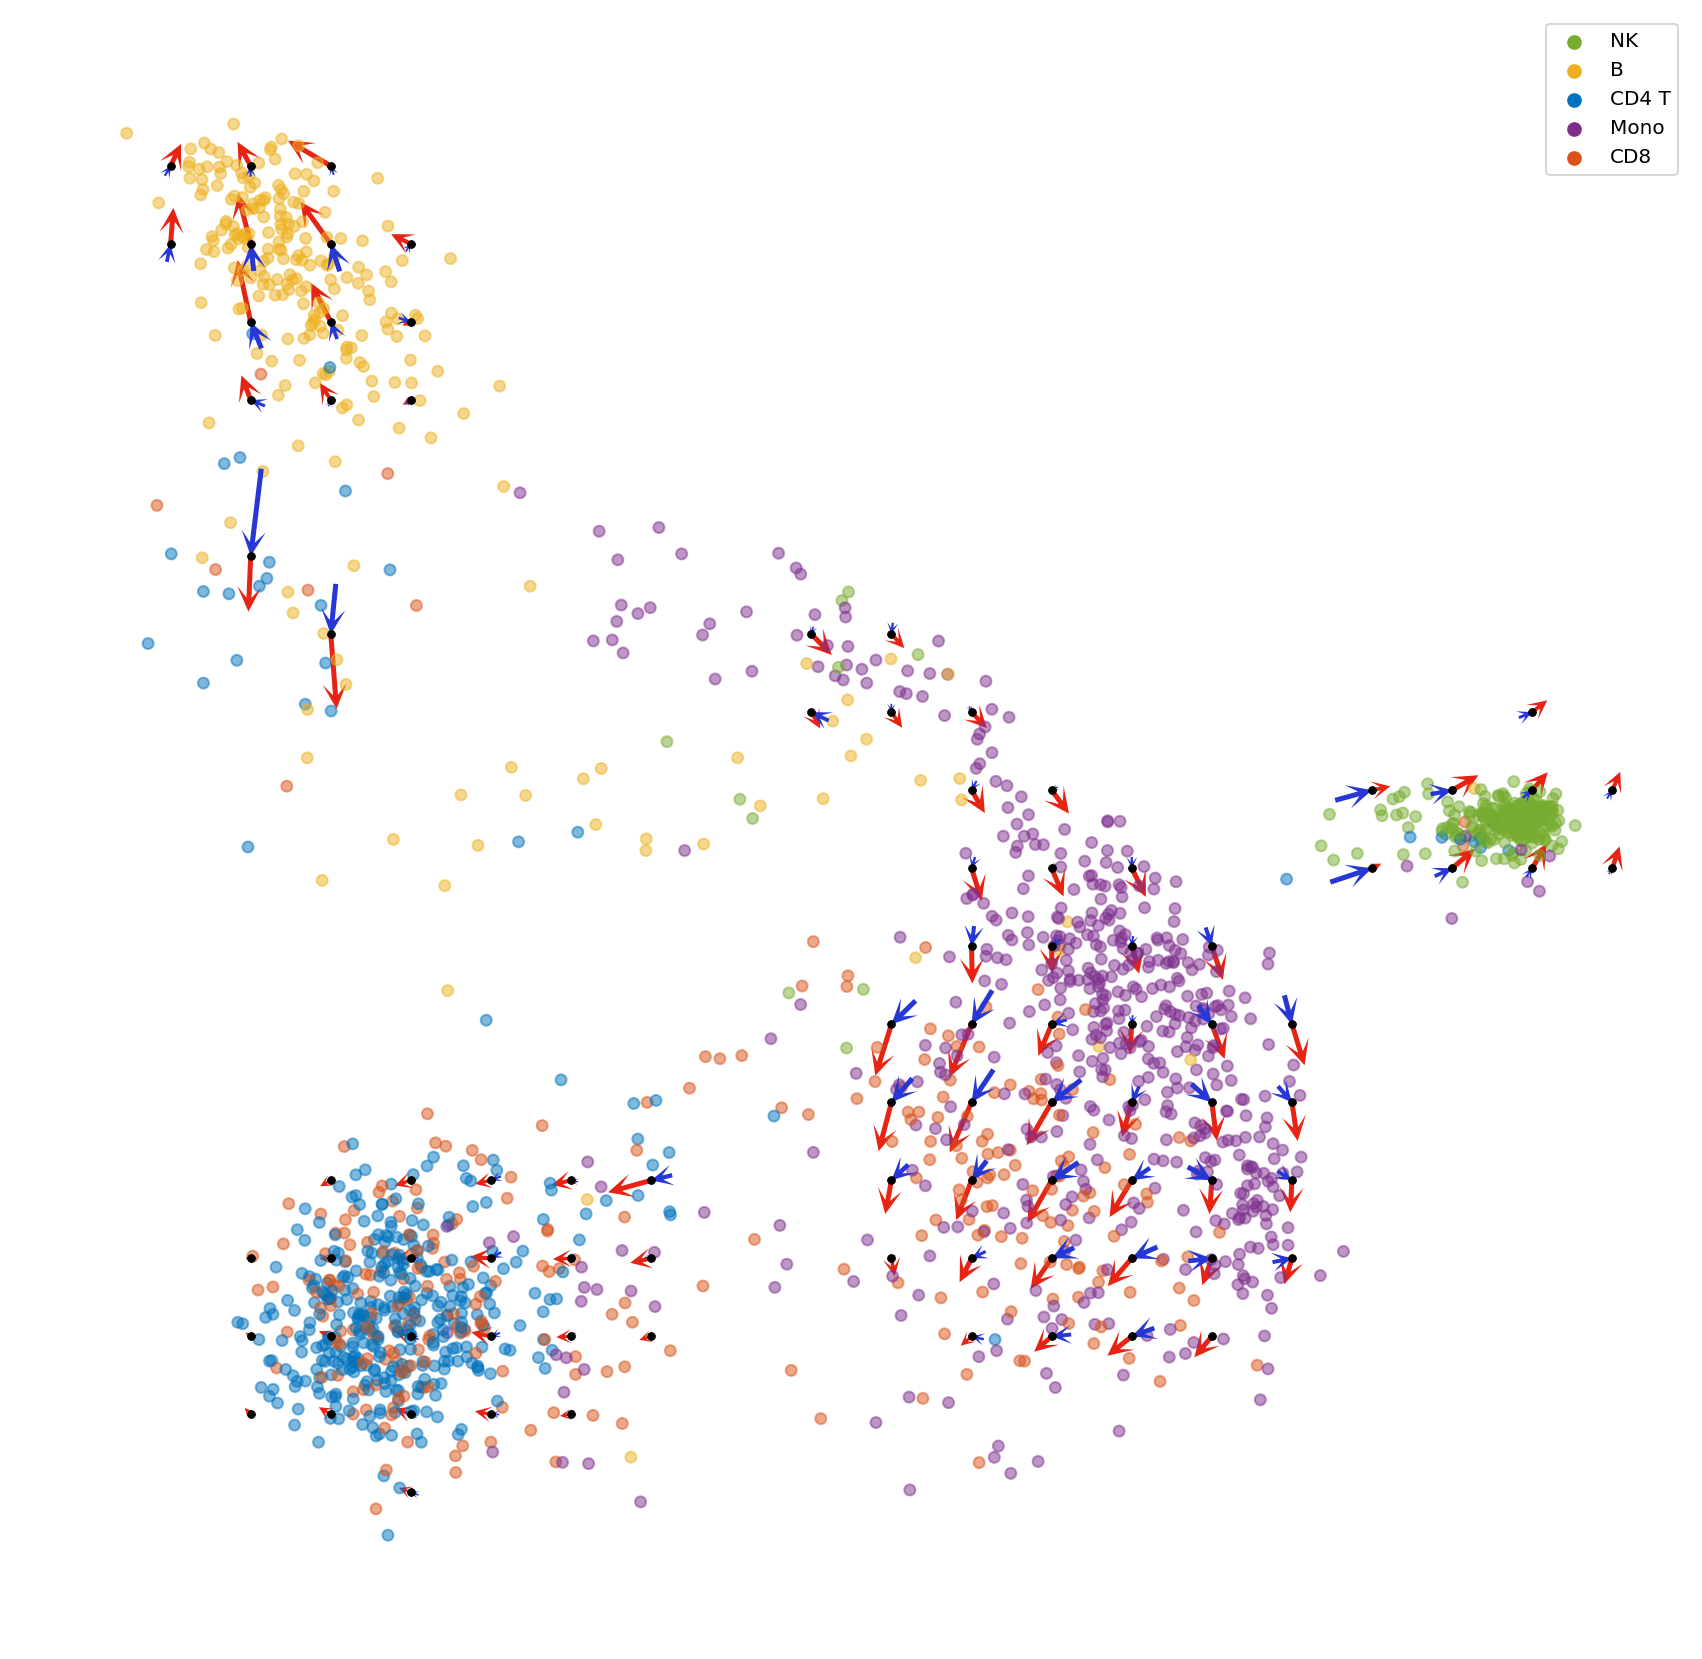

In [31]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(15,15))
arr_scale=1
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=arr_scale)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, pivot='tip',
                    arr_scale=arr_scale,cell_alpha=0.5,write_labels=True)

In [32]:
# Calculate JOINT t-SNE embedding based on normalized spliced counts. Perform analysis in t-SNE space.
n_pcs_S = 25
n_pcs_P = 10
pa.fit_pcs(vlm,'S_norm','pcs_S',n_pcs_S)
pa.fit_pcs(vlm,'P_norm','pcs_P',n_pcs_P)

In [33]:
def fit_JUMAP(vlm, pc_space_name1, pc_space_name2, n_pcs1, n_pcs2, ts_name, init = 'spectral', repulsion_strength = 1.0, seed=None):
    #bh_tsne = TSNE(random_state=seed)
    data = {'X1': getattr(vlm,pc_space_name1)[:, :n_pcs1], 'X2': getattr(vlm,pc_space_name2)[:, :n_pcs2]}
    bh_tsne = JUMAP(init = init, repulsion_strength=repulsion_strength, random_state = seed).fit_transform(X = data, method = "auto")
    setattr(vlm,ts_name,bh_tsne)

In [34]:
fit_JUMAP(vlm,'pcs_P', 'pcs_S', n_pcs_P, n_pcs_S, 'umap', 'spectral', 0.02)
#pa.fit_tsne(vlm, 'pcs', 'tsne', 25,seed=20)
pa.identify_embedding_knn(vlm,'umap',[0,1])
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_umap','rna_velo_gene_ind')
# visulization
#pa.visualize_velocity_projection(vlm, 'delta_S_in_S_umap')

Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP
Always use exact mode: JUMAP


In [35]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_umap','prot_velo_prot_ind')


In [36]:
#pa.visualize_velocity_projection(vlm, 'delta_P_in_S_umap')


In [41]:
# Prepare and perform grid embedding.
if hasattr(vlm,'mass_filter'):
    delattr(vlm,'mass_filter')
pa.initialize_grid_embedding(vlm, n_neighbors=20)
uv_multiplier=0.06
pa.calculate_grid_arrows(vlm,'delta_S_in_S_umap', '_rna', min_mass=0.5,uv_multiplier=uv_multiplier+0.06)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_umap', '_prot', min_mass=0.5,uv_multiplier=uv_multiplier)

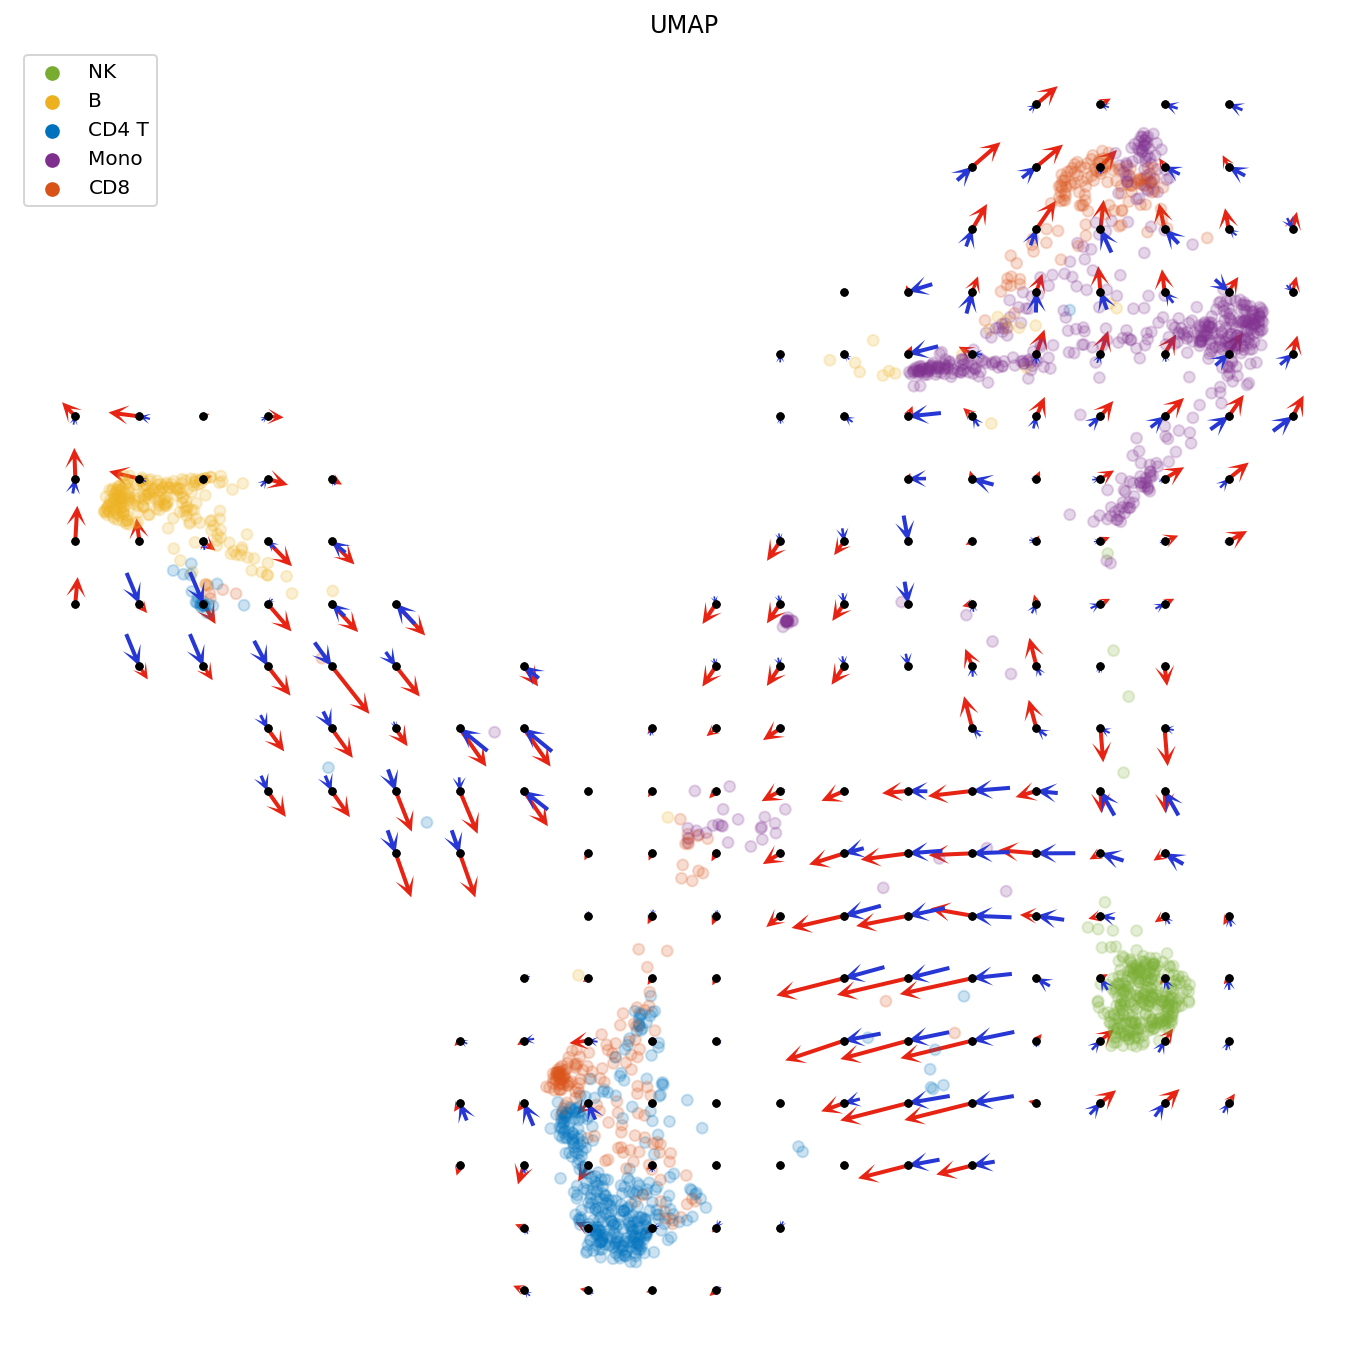

In [42]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
#b_protv = [253/255,1/255,1/255]
plt.figure(figsize=(12,12))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=1)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, 
                    pivot='tip',cell_alpha=0.2,arr_scale=1,write_labels=True)
plt.title('UMAP')
plt.savefig("/data/hoan/plots/citeseq_umap.pdf")

<Figure size 1080x1080 with 0 Axes>

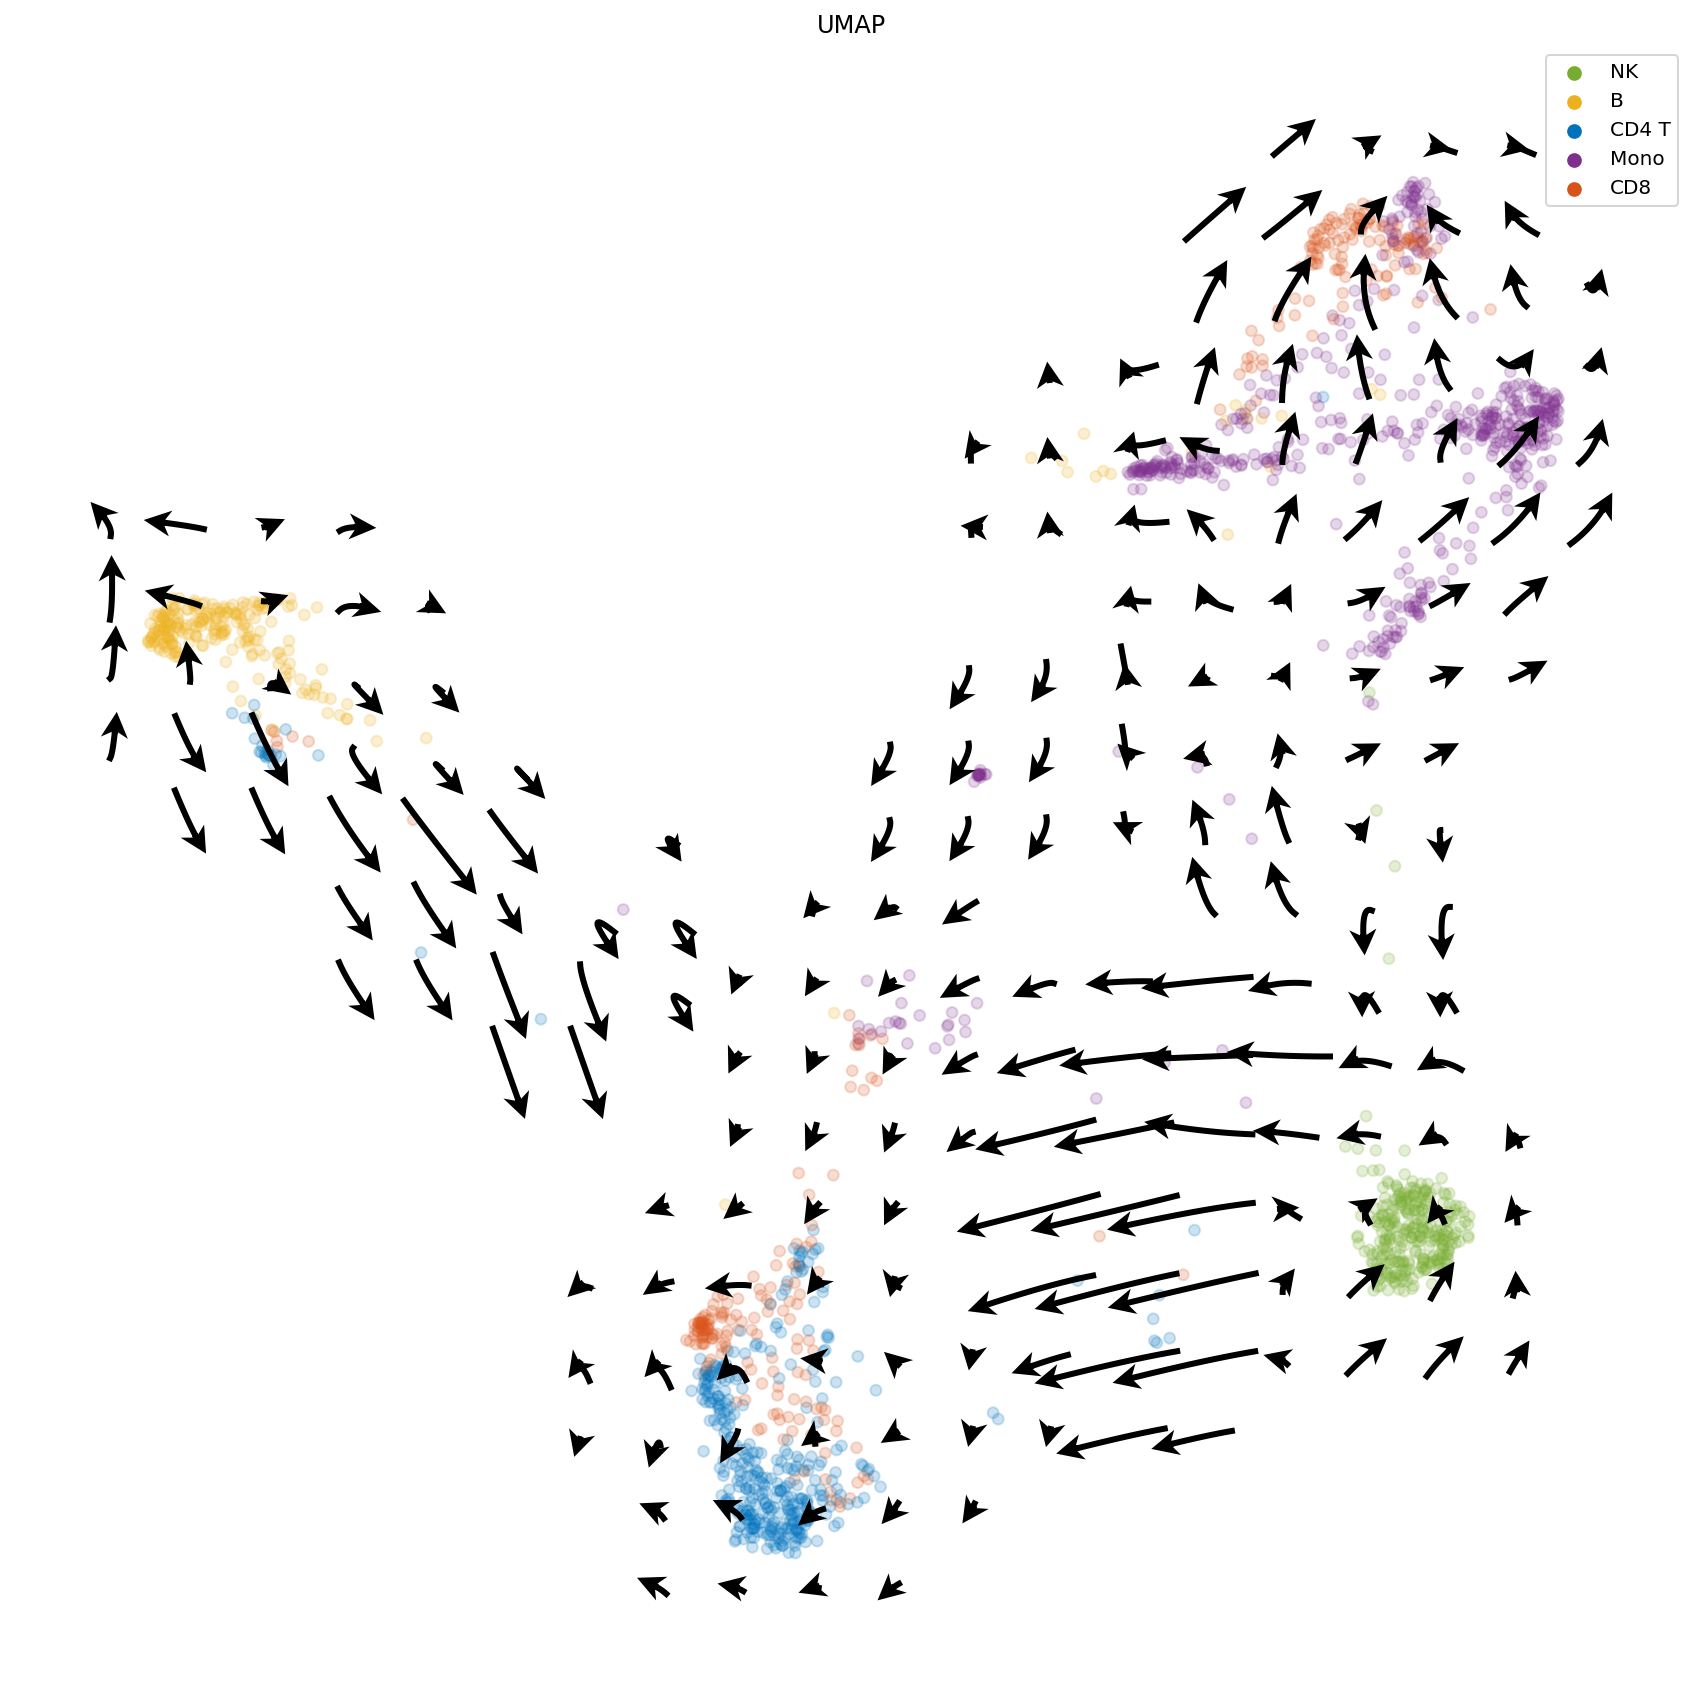

In [44]:
plt.figure(figsize=(15,15))
plt.figure(figsize=(15,15))
pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True, arr_len_scal=0.025,cell_alpha=0.2,write_labels=True)
plt.title("UMAP")
plt.savefig("/data/hoan/plots/citeseq_bez_umap.pdf")